# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.

**Important Notes**:
1. Be sure to **document** all of your decisions, as well as your intermediate and final results. Make sure your conclusions and analyses are clearly presented. Don't make us dig into your code or walls of printed results to try to draw conclusions from your code.
2. If you use code from someone else (e.g. Github, Stack Overflow, ChatGPT, etc) you **must be transparent about it**. Document your sources and explain how you adapted any partial solutions to creat **your** solution.



## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

### Preface: Some code to get you started

What follows is some **very simple** code for training an MLP on MNIST. The point of this code is to get you up and running (and to verify that your Python environment has all needed dependencies).

**Note**: As you read through my code and execute it, this would be a good time to think about *abstracting* **your** model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

## **Import**

In [1]:
# Import standard libraries
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import wandb
from sklearn.metrics import accuracy_score, precision_score
import matplotlib.pyplot as plt


# Import PyTorch and Torchvion
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms


### ***Further settings***

In [2]:
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# fix random seed for reproducibility
torch.manual_seed(808)

#### A basic, parameterized MLP

This is a very basic implementation of a Multilayer Perceptron. Don't waste too much time trying to figure out how it works -- the important detail is that it allows you to pass in a list of input, hidden layer, and output *widths*. **Your** implementation should also support this for the exercises to come.

# *Exercise 1.1: A baseline MLP*

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

###  **Model architecure**

In [3]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2, output_size,dropout_rate):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.dropout = nn.Dropout(p=dropout_rate)  
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.out = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)          
        x = F.relu(self.fc2(x))
        x = self.dropout(x)          
        return self.out(x)


### **Data preparation**

In [4]:

# Training hyperparameters
batch_size = 128
val_fraction=0.1

# Load the MNIST dataset with standard normalization, and split the training set into training and validation subsets
def load_mnist_datasets(data_dir='./data', val_fraction=val_fraction, download=True):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    full_dataset = MNIST(root=data_dir, train=True, download=download, transform=transform)
    test = MNIST(root=data_dir, train=False, download=download, transform=transform)

    total_train = len(full_dataset)
    val_size = int(total_train * val_fraction)
    train_size = total_train - val_size

    train, val = torch.utils.data.random_split(full_dataset, [train_size, val_size]) 
    # Create DataLoaders
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader
train_loader, val_loader, test_loader = load_mnist_datasets()


### **Traning configuration**

In [5]:

def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, device,
                patience, min_delta,
                delta_overfit, overfit_patience,
                wandb_project=None, wandb_run_name=None):
    
    model.to(device)

    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    overfit_epochs = 0
    insufficient_change_epochs = 0
    prev_val_loss = None

    # Inizializza wandb una sola volta all'inizio del training (se richiesto)
    if wandb_project is not None:
        wandb.init(project=wandb_project, name=wandb_run_name, reinit=True)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss, val_acc = 0, 0
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
            val_loss /= val_total
            val_acc = val_correct / val_total
            val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train_Loss: {train_loss:.4f} | Train_Acc: {train_acc:.4f}")
        print(f"  Val_Loss: {val_loss:.4f} | Val_Acc: {val_acc:.4f}\n")

        # Log su wandb
        if wandb_project is not None:
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc
            })

        # Early stopping e controllo overfitting
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            overfit_epochs = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            if val_loss > best_val_loss + delta_overfit:
                overfit_epochs += 1
                print(f"Warning:Change in the trend of value  val_loss: best value= {best_val_loss:.4f} | current value= {val_loss:.4f}")
                if overfit_epochs >= overfit_patience: 
                    print(f"Early stopping due to overfitting\nEpoch {epoch+1}: val_loss is INCREASING for {overfit_patience} epochs (hight risk for overfitting)")
                    break
            else:
                overfit_epochs = 0

        if prev_val_loss is None:
            prev_val_loss = val_loss
            continue

        delta = abs(prev_val_loss - val_loss)
        if delta >= min_delta:
            insufficient_change_epochs = 0
        else:
            insufficient_change_epochs += 1
            print(f"  Δ(val_loss) < {min_delta} for {insufficient_change_epochs} consecutive epoch(s)")
            if insufficient_change_epochs >= patience:
                print(f"Early stopping due to stagnation\nEpoch {epoch+1}: No significant change (|Δ| < {min_delta}) for {patience} consecutive epochs.")
                break

        prev_val_loss = val_loss

    # Chiudi wandb alla fine
    if wandb_project is not None:
        wandb.finish()

    return train_losses, val_losses


### **Evaluation configuration**

In [6]:


def evaluate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0
    all_preds = []
    all_labels = []
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total += labels.size(0)

    avg_loss = running_loss / total
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')  # weighted per multilabel bilanciato
    

    return avg_loss, accuracy, precision


## ***Model Traning*** 

In [9]:

#Model hyperparameters
input_size=28*28
hidden_size1=128
hidden_size2=64
output_size=10
dropout_rate=0.2  # Dropout 20%
num_epochs = 50
learning_rate=0.001

#Overfitting control parameters
patience=8
min_delta=0.001
delta_overfit=0.01
overfit_patience=8

#Wandb parameters
wandb_project=None
wandb_run_name=None

model = MLP(input_size, hidden_size1, hidden_size2, output_size, dropout_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, device, patience, min_delta, 
                                       delta_overfit, overfit_patience,wandb_project="AML_MLP",
    wandb_run_name="2lp_run" )



epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_acc,▁▅▆▆▇▇▇▇▇▇▇▇████████████████████████████
train_loss,█▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▄▆▆▆▇▇▇▇▇▇▇▇▇▇█▇█▇▇██▇▇▇▇█▇▇▇▇█████▇██
val_loss,█▅▃▃▃▂▁▁▁▁▂▁▂▁▁▂▁▁▁▂▂▂▁▃▂▂▂▁▁▂▁▁▁▂▁▂▂▂▂▂
epoch,47
train_acc,0.99022
train_loss,0.02943
val_acc,0.97983
val_loss,0.08533


Epoch 1/50
  Train_Loss: 0.4171 | Train_Acc: 0.8742
  Val_Loss: 0.1777 | Val_Acc: 0.9447

Epoch 2/50
  Train_Loss: 0.1930 | Train_Acc: 0.9433
  Val_Loss: 0.1262 | Val_Acc: 0.9578

Epoch 3/50
  Train_Loss: 0.1442 | Train_Acc: 0.9570
  Val_Loss: 0.1189 | Val_Acc: 0.9620

Epoch 4/50
  Train_Loss: 0.1209 | Train_Acc: 0.9639
  Val_Loss: 0.0898 | Val_Acc: 0.9718

Epoch 5/50
  Train_Loss: 0.1043 | Train_Acc: 0.9684
  Val_Loss: 0.0838 | Val_Acc: 0.9732

Epoch 6/50
  Train_Loss: 0.0935 | Train_Acc: 0.9716
  Val_Loss: 0.0924 | Val_Acc: 0.9720

Epoch 7/50
  Train_Loss: 0.0848 | Train_Acc: 0.9733
  Val_Loss: 0.0761 | Val_Acc: 0.9765

Epoch 8/50
  Train_Loss: 0.0813 | Train_Acc: 0.9745
  Val_Loss: 0.0779 | Val_Acc: 0.9757

Epoch 9/50
  Train_Loss: 0.0699 | Train_Acc: 0.9786
  Val_Loss: 0.0827 | Val_Acc: 0.9743

Epoch 10/50
  Train_Loss: 0.0691 | Train_Acc: 0.9784
  Val_Loss: 0.0749 | Val_Acc: 0.9767

Epoch 11/50
  Train_Loss: 0.0657 | Train_Acc: 0.9790
  Val_Loss: 0.0787 | Val_Acc: 0.9765

Epoch 12

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_acc,▁▅▆▆▇▇▇▇▇▇▇███████████████████████████
train_loss,█▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▄▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████▇▇████
val_loss,█▅▄▂▂▂▁▁▂▁▂▁▁▁▂▁▁▂▂▁▁▁▂▁▂▁▂▂▂▂▂▂▂▂▂▂▂▂
epoch,38
train_acc,0.98939
train_loss,0.03091
val_acc,0.9795
val_loss,0.09337


Test Loss: 0.0942 | Test Accuracy: 0.9793 | Test Precision: 0.9793


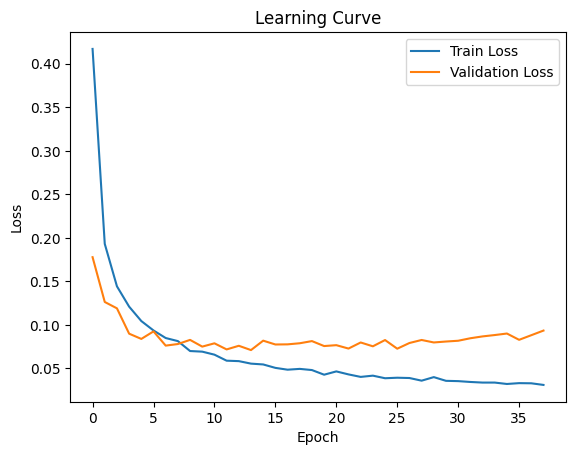

In [10]:
mlp_test_loss, mlp_test_acc, mlp_precision = evaluate(model, test_loader, criterion, device)

print(f"Test Loss: {mlp_test_loss:.4f} | Test Accuracy: {mlp_test_acc:.4f} | Test Precision: {mlp_precision:.4f}")

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()


# *Exercise 1.2: Adding Residual Connections*

Implement a variant of your parameterized MLP network to support **residual** connections. Your network should be defined as a composition of **residual MLP** blocks that have one or more linear layers and add a skip connection from the block input to the output of the final linear layer.

**Compare** the performance (in training/validation loss and test accuracy) of your MLP and ResidualMLP for a range of depths. Verify that deeper networks **with** residual connections are easier to train than a network of the same depth **without** residual connections.

**For extra style points**: See if you can explain by analyzing the gradient magnitudes on a single training batch *why* this is the case. 

###  **Model architecure**

In [11]:

class ResidualBlock(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, input_size)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x):
        identity = x
        out = F.relu(self.fc1(x))
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.dropout2(out)
        out += identity
        out = F.relu(out)
        return out

class ResidualMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_blocks,dropout_rate):
        super(ResidualMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.blocks = nn.Sequential(*[
            ResidualBlock(hidden_size, hidden_size, dropout_rate) for _ in range(num_blocks)
        ])
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(-1, self.fc1.in_features)  # usa self.fc1.in_features invece di input_size direttamente
        x = F.relu(self.fc1(x))
        x = self.blocks(x)
        x = self.fc2(x)
        return x


In [ ]:

input_size=28*28
hidden_size=64
num_blocks=2
dropout_rate=0.2
res_model=ResidualMLP(input_size, hidden_size,output_size, num_blocks, dropout_rate)
optimizer = torch.optim.Adam(res_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses = train_model(res_model, train_loader, val_loader, optimizer, criterion, num_epochs, device, patience, min_delta, 
                                       delta_overfit, overfit_patience,wandb_project="AML_ResMLP",
    wandb_run_name="ResidualMLP" )



Epoch 1/50
  Train_Loss: 0.3453 | Train_Acc: 0.8986
  Val_Loss: 0.1823 | Val_Acc: 0.9423

Epoch 2/50
  Train_Loss: 0.1564 | Train_Acc: 0.9524
  Val_Loss: 0.1282 | Val_Acc: 0.9625

Epoch 3/50
  Train_Loss: 0.1104 | Train_Acc: 0.9666
  Val_Loss: 0.1079 | Val_Acc: 0.9655

Epoch 4/50
  Train_Loss: 0.0885 | Train_Acc: 0.9723
  Val_Loss: 0.1015 | Val_Acc: 0.9688

Epoch 5/50
  Train_Loss: 0.0741 | Train_Acc: 0.9768
  Val_Loss: 0.0892 | Val_Acc: 0.9698

Epoch 6/50
  Train_Loss: 0.0628 | Train_Acc: 0.9801
  Val_Loss: 0.0928 | Val_Acc: 0.9722



Test Loss: 0.1122 | Test Accuracy: 0.9782 | Test Precision: 0.9783


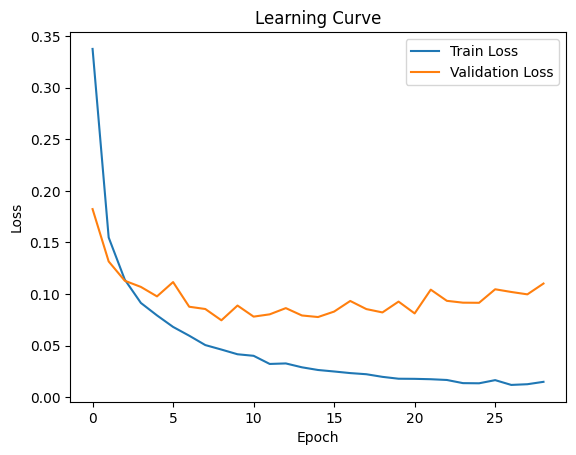

In [ ]:
res_test_loss, res_test_acc, res_precision = evaluate(res_model, test_loader, criterion, device)

print(f"Test Loss: {res_test_loss:.4f} | Test Accuracy: {res_test_acc:.4f} | Test Precision: {res_precision:.4f}")

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [ ]:

# Stampa comparativa
print("Confronto MLP vs ResidualMLP sul TEST SET")
print("-" * 60)
print(f"{'':<15} | {'Loss':<10} | {'Accuracy':<10} | {'Precision':<10}")
print("-" * 60)
print(f"{'MLP':<15} | {mlp_test_loss:<10.4f} | {mlp_test_acc:<10.4f} | {mlp_precision:<10.4f}")
print(f"{'ResidualMLP':<15} | {res_test_loss:<10.4f} | {res_test_acc:<10.4f} | {res_precision:<10.4f}")


Confronto MLP vs ResidualMLP sul TEST SET
------------------------------------------------------------
                | Loss       | Accuracy   | Precision 
------------------------------------------------------------
MLP             | 0.0843     | 0.9814     | 0.9814    
ResidualMLP     | 0.1122     | 0.9782     | 0.9783    


### Exercise 1.3: Rinse and Repeat (but with a CNN)

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR-10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Tip**: Feel free to reuse the ResNet building blocks defined in `torchvision.models.resnet` (e.g. [BasicBlock](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L59) which handles the cascade of 3x3 convolutions, skip connections, and optional downsampling). This is an excellent exercise in code diving. 

**Spoiler**: Depending on the optional exercises you plan to do below, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

In [ ]:
# Your code here.

-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit. Each exercise is designed to require you to dig your hands **deep** into the guts of your models in order to do new and interesting things.

**Note**: These exercises are designed to use your small, custom CNNs and small datasets. This is to keep training times reasonable. If you have a decent GPU, feel free to use pretrained ResNets and larger datasets (e.g. the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset at 160px).

### Exercise 2.1: *Fine-tune* a pre-trained model
Train one of your residual CNN models from Exercise 1.3 on CIFAR-10. Then:
1. Use the pre-trained model as a **feature extractor** (i.e. to extract the feature activations of the layer input into the classifier) on CIFAR-100. Use a **classical** approach (e.g. Linear SVM, K-Nearest Neighbor, or Bayesian Generative Classifier) from scikit-learn to establish a **stable baseline** performance on CIFAR-100 using the features extracted using your CNN.
2. Fine-tune your CNN on the CIFAR-100 training set and compare with your stable baseline. Experiment with different strategies:
    - Unfreeze some of the earlier layers for fine-tuning.
    - Test different optimizers (Adam, SGD, etc.).

Each of these steps will require you to modify your model definition in some way. For 1, you will need to return the activations of the last fully-connected layer (or the global average pooling layer). For 2, you will need to replace the original, 10-class classifier with a new, randomly-initialized 100-class classifier.

In [ ]:
# Your code here.

### Exercise 2.2: *Distill* the knowledge from a large model into a smaller one
In this exercise you will see if you can derive a *small* model that performs comparably to a larger one on CIFAR-10. To do this, you will use [Knowledge Distillation](https://arxiv.org/abs/1503.02531):

> Geoffrey Hinton, Oriol Vinyals, and Jeff Dean. Distilling the Knowledge in a Neural Network, NeurIPS 2015.

To do this:
1. Train one of your best-performing CNNs on CIFAR-10 from Exercise 1.3 above. This will be your **teacher** model.
2. Define a *smaller* variant with about half the number of parameters (change the width and/or depth of the network). Train it on CIFAR-10 and verify that it performs *worse* than your **teacher**. This small network will be your **student** model.
3. Train the **student** using a combination of **hard labels** from the CIFAR-10 training set (cross entropy loss) and **soft labels** from predictions of the **teacher** (Kulback-Leibler loss between teacher and student).

Try to optimize training parameters in order to maximize the performance of the student. It should at least outperform the student trained only on hard labels in Setp 2.

**Tip**: You can save the predictions of the trained teacher network on the training set and adapt your dataloader to provide them together with hard labels. This will **greatly** speed up training compared to performing a forward pass through the teacher for each batch of training.

In [ ]:
# Your code here.

### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.3 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your CNN implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes. Try your implementation out using a pre-trained ResNet-18 model and some images from the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset -- I suggest you start with the low resolution version of images at 160px.

In [ ]:
# Your code here.